In [124]:
set.seed(42)
train_set = read.delim("data/train_set.txt", sep = " ")
test_set = read.delim("data/test_set.txt", sep = " ")

train_set["rain"] = NULL
train_set["rain_log"] = NULL

test_set["rain"] = NULL
test_set["rain_log"] = NULL

# WE WILL DELETE ALL MONTH VARIABLES
month_names = paste("month", 2:12, sep = "")
train_set[, month_names] = NULL
test_set[, month_names] = NULL

train_set[,"rain_class"] = as.factor(train_set[,"rain_class"])
test_set[,"rain_class"] = as.factor(test_set[,"rain_class"])

n_train = nrow(train_set)

In [126]:
exp_var = setdiff(names(train_set), c("rain_class"))
exp_var

[1] "ff"           "t"            "td"           "hu"           "dd"          
 [6] "precip_log"   "ws_arome"     "p3031_arome"  "u10_arome"    "v10_arome"   
[11] "t2m_arome"    "d2m_arome"    "r_arome"      "tp_arome_log" "msl_arome"

In [186]:
x_train = train_set[, exp_var]
x_test = test_set[, exp_var]

y_train = as.factor(train_set[,"rain_class"])
y_test = as.factor(test_set[,"rain_class"])

In [46]:
library(rpart)

In [47]:
confusion_matrix = function(pred_class, true_class){
    tab = table(pred_class, true_class)
    print("Confusion matrix")
    print(tab)
    acc = sum(diag(tab)) / sum(tab)
    print(paste("Prediction accuracy : ", acc))
}

## 5.2. Decision Tree

In [142]:
tree = rpart(rain_class ~ ., data = train_set, control = rpart.control(cp = 0.001, nsplit = 15), method = "class")
summary(tree)

Call:
rpart(formula = rain_class ~ ., data = train_set, method = "class", 
    control = rpart.control(cp = 0.001, nsplit = 15))
  n= 550 

            CP nsplit rel error    xerror       xstd
1  0.085443038      0 1.0000000 1.0000000 0.03669298
2  0.044303797      2 0.8291139 0.8955696 0.03709201
3  0.031645570      4 0.7405063 0.8575949 0.03710379
4  0.018987342      5 0.7088608 0.8702532 0.03710772
5  0.015822785      6 0.6898734 0.9050633 0.03707802
6  0.012658228      7 0.6740506 0.9082278 0.03707237
7  0.011867089      9 0.6487342 0.9335443 0.03700945
8  0.009493671     13 0.6012658 0.9335443 0.03700945
9  0.007911392     16 0.5727848 0.9208861 0.03704486
10 0.006329114     23 0.5158228 0.9240506 0.03703675
11 0.005274262     25 0.5031646 0.9398734 0.03698878
12 0.004746835     28 0.4873418 0.9398734 0.03698878
13 0.003164557     30 0.4778481 0.9430380 0.03697771
14 0.001000000     31 0.4746835 0.9398734 0.03698878

Variable importance
   u10_arome           hu    msl_arome      

In [143]:
summary(tree)$variable.importance

Call:
rpart(formula = rain_class ~ ., data = train_set, method = "class", 
    control = rpart.control(cp = 0.001, nsplit = 15))
  n= 550 

            CP nsplit rel error    xerror       xstd
1  0.085443038      0 1.0000000 1.0000000 0.03669298
2  0.044303797      2 0.8291139 0.8955696 0.03709201
3  0.031645570      4 0.7405063 0.8575949 0.03710379
4  0.018987342      5 0.7088608 0.8702532 0.03710772
5  0.015822785      6 0.6898734 0.9050633 0.03707802
6  0.012658228      7 0.6740506 0.9082278 0.03707237
7  0.011867089      9 0.6487342 0.9335443 0.03700945
8  0.009493671     13 0.6012658 0.9335443 0.03700945
9  0.007911392     16 0.5727848 0.9208861 0.03704486
10 0.006329114     23 0.5158228 0.9240506 0.03703675
11 0.005274262     25 0.5031646 0.9398734 0.03698878
12 0.004746835     28 0.4873418 0.9398734 0.03698878
13 0.003164557     30 0.4778481 0.9430380 0.03697771
14 0.001000000     31 0.4746835 0.9398734 0.03698878

Variable importance
   u10_arome           hu    msl_arome      

u10_arome           hu    msl_arome           dd  p3031_arome tp_arome_log 
    39.34045     37.47504     35.42458     31.70332     30.64921     28.85287 
  precip_log            t    t2m_arome     ws_arome           td    d2m_arome 
    28.66893     28.49728     24.27877     22.68688     21.78570     20.11613 
     r_arome    v10_arome           ff 
    19.94201     16.51605     13.96059

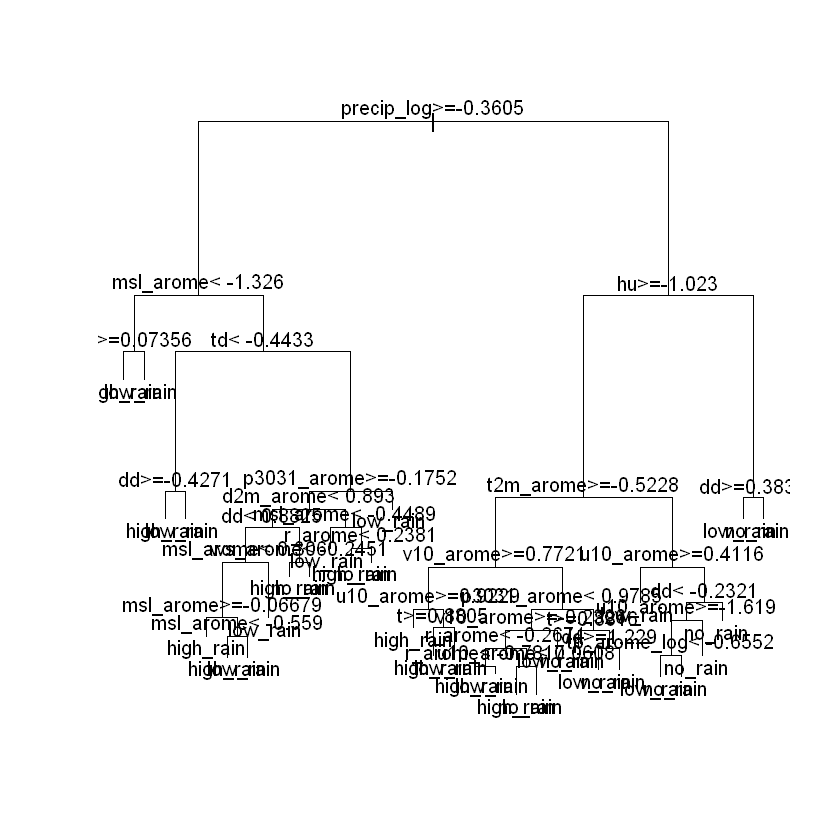

In [144]:
plot(tree)
text(tree)

In [145]:
confusion_matrix(predict(tree, newdata = train_set, type = "class"), y_train)
confusion_matrix(predict(tree, newdata = test_set, type = "class"), y_test)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       123       33       9
  low_rain         14      164      39
  no_rain          18       37     113
[1] "Prediction accuracy :  0.727272727272727"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        16       16       9
  low_rain         12       26      20
  no_rain           5       16      18
[1] "Prediction accuracy :  0.434782608695652"


#### Cross validation

In [146]:
y_train_num = rep(0, times = n_train)
y_train_num[y_train == 'no_rain'] = 1
y_train_num[y_train == 'low_rain'] = 2
y_train_num[y_train == 'high_rain'] = 3

In [169]:
get_train_acc = function(pred_class){
    tab = table(pred_class, y_train_num)
    acc = sum(diag(tab)) / sum(tab)
    return(acc)
}

In [ ]:
xerr = (xmat - y_train_num)^2
CVerr = apply(xerr, 2 , sum)
CVerr

In [174]:
xmat = xpred.rpart(tree)
train_acc = apply(xmat, 2, get_train_acc)


The optimal `cp` is determined by the following

In [175]:
optimal.cp = as.numeric(attributes(which.min(train_acc))$names)
optimal.cp

[1] 0.01733299

In [181]:
optimal.tree = rpart(rain_class ~ ., data = train_set, control = rpart.control(cp = optimal.cp, nsplit = 15), method = "class")
summary(optimal.tree)

Call:
rpart(formula = rain_class ~ ., data = train_set, method = "class", 
    control = rpart.control(cp = optimal.cp, nsplit = 15))
  n= 550 

          CP nsplit rel error    xerror       xstd
1 0.08544304      0 1.0000000 1.0000000 0.03669298
2 0.04430380      2 0.8291139 0.8765823 0.03710674
3 0.03164557      4 0.7405063 0.8860759 0.03710159
4 0.01898734      5 0.7088608 0.8544304 0.03710159
5 0.01733299      6 0.6898734 0.8417722 0.03708784

Variable importance
  precip_log    msl_arome           hu tp_arome_log            t    t2m_arome 
          15           13           11           10            7            7 
          td     ws_arome    d2m_arome    u10_arome    v10_arome      r_arome 
           7            7            7            6            4            3 
          ff 
           2 

Node number 1: 550 observations,    complexity param=0.08544304
  predicted class=low_rain   expected loss=0.5745455  P(node) =1
    class counts:   155   234   161
   probabilities: 

In [182]:
confusion_matrix(predict(optimal.tree, newdata = train_set, type = "class"), y_train)
confusion_matrix(predict(optimal.tree, newdata = test_set, type = "class"), y_test)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        91       32      11
  low_rain         51      160      69
  no_rain          13       42      81
[1] "Prediction accuracy :  0.603636363636364"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        14       14       9
  low_rain         16       33      23
  no_rain           3       11      15
[1] "Prediction accuracy :  0.449275362318841"


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm



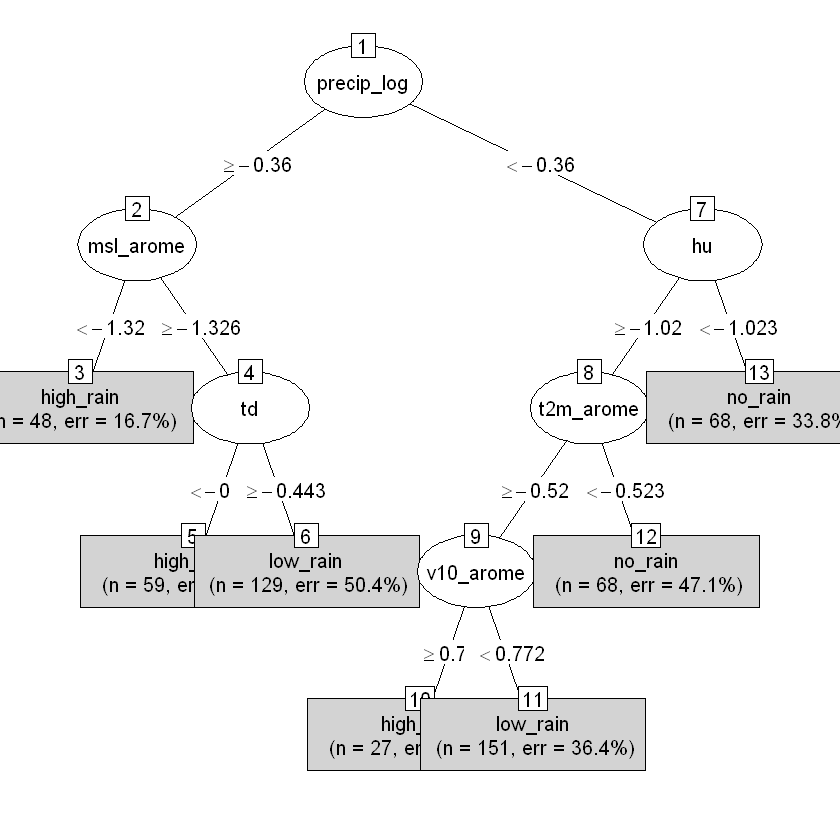

In [183]:
library(partykit)
plot(as.party(optimal.tree), type = "simple")

## Aggregation of Models - Random Forest


In [184]:
library(randomForest)

randomForest 4.7-1

Type rfNews() to see new features/changes/bug fixes.



In [190]:
help(randomForest)

randomForest           package:randomForest            R Documentation

_C_l_a_s_s_i_f_i_c_a_t_i_o_n _a_n_d _R_e_g_r_e_s_s_i_o_n _w_i_t_h _R_a_n_d_o_m _F_o_r_e_s_t

_D_e_s_c_r_i_p_t_i_o_n:

     'randomForest' implements Breiman's random forest algorithm (based
     on Breiman and Cutler's original Fortran code) for classification
     and regression.  It can also be used in unsupervised mode for
     assessing proximities among data points.

_U_s_a_g_e:

     ## S3 method for class 'formula'
     randomForest(formula, data=NULL, ..., subset, na.action=na.fail)
     ## Default S3 method:
     randomForest(x, y=NULL,  xtest=NULL, ytest=NULL, ntree=500,
                  mtry=if (!is.null(y) && !is.factor(y))
                  max(floor(ncol(x)/3), 1) else floor(sqrt(ncol(x))),
                  weights=NULL,
                  replace=TRUE, classwt=NULL, cutoff, strata,
                  sampsize = if (replace) nrow(x) else ceili

In [187]:
random.forest = randomForest(rain_class ~ ., data = train_set, xtest = x_test, ytest = y_test, 
        ntree = 500, do.trace = 50, importance = TRUE)

ntree      OOB      1      2      3|    Test      1      2      3
   50:  47.64% 49.03% 38.89% 59.01%|  53.62% 48.48% 43.10% 70.21%
  100:  47.09% 47.74% 40.17% 56.52%|  54.35% 51.52% 43.10% 70.21%
  150:  48.00% 47.74% 38.03% 62.73%|  52.17% 45.45% 41.38% 70.21%
  200:  48.91% 49.03% 38.89% 63.35%|  50.72% 42.42% 41.38% 68.09%
  250:  47.27% 46.45% 37.61% 62.11%|  50.72% 42.42% 41.38% 68.09%
  300:  46.55% 44.52% 38.03% 60.87%|  49.28% 39.39% 39.66% 68.09%
  350:  46.00% 43.87% 37.61% 60.25%|  49.28% 36.36% 39.66% 70.21%
  400:  46.00% 44.52% 36.75% 60.87%|  50.00% 36.36% 41.38% 70.21%
  450:  46.91% 43.87% 37.61% 63.35%|  50.72% 39.39% 41.38% 70.21%
  500:  47.45% 44.52% 38.03% 63.98%|  52.17% 42.42% 43.10% 70.21%


 Number of variables randomly sampled as candidates at each split by default is

In [199]:
random.forest$confusion

,high_rain,low_rain,no_rain,class.error
high_rain,86,55,14,0.4451613
low_rain,41,145,48,0.3803419
no_rain,17,86,58,0.6397516


In [200]:
random.forest$err.rate

OOB,high_rain,low_rain,no_rain
0.5165877,0.3962264,0.5794393,0.5098039
0.5373134,0.4886364,0.5641026,0.5384615
0.5428571,0.5309735,0.5351351,0.5655738
0.5434783,0.4920635,0.5472637,0.5864662
0.5454545,0.5111111,0.5047170,0.6351351
0.5326923,0.4965517,0.5133929,0.5960265
0.5328330,0.4832215,0.5064935,0.6209150
0.5351852,0.4966887,0.4978541,0.6282051
0.5238971,0.5065789,0.4806867,0.6037736
0.5045704,0.4967320,0.4316239,0.6187500


In [189]:
attributes(random.forest)
random.forest$mtry

$names
 [1] "call"            "type"            "predicted"       "err.rate"       
 [5] "confusion"       "votes"           "oob.times"       "classes"        
 [9] "importance"      "importanceSD"    "localImportance" "proximity"      
[13] "ntree"           "mtry"            "forest"          "y"              
[17] "test"            "inbag"           "terms"          

$class
[1] "randomForest.formula" "randomForest"

[1] 3

We will test different values of this hyperparameter to see the influences to the error rate

In [193]:
randomForest(rain_class ~ ., data = train_set, xtest = x_test, ytest = y_test, 
        ntree = 500, do.trace = 50, importance = TRUE, mtry = 6)

ntree      OOB      1      2      3|    Test      1      2      3
   50:  48.00% 40.65% 44.02% 60.87%|  52.90% 36.36% 51.72% 65.96%
  100:  46.55% 41.94% 38.46% 62.73%|  53.62% 39.39% 48.28% 70.21%
  150:  47.27% 41.94% 41.03% 61.49%|  52.17% 39.39% 46.55% 68.09%
  200:  47.27% 42.58% 40.17% 62.11%|  52.17% 39.39% 46.55% 68.09%
  250:  47.82% 43.87% 40.60% 62.11%|  50.72% 39.39% 44.83% 65.96%
  300:  47.82% 41.94% 41.45% 62.73%|  49.28% 39.39% 39.66% 68.09%
  350:  47.82% 42.58% 42.31% 60.87%|  50.00% 39.39% 41.38% 68.09%
  400:  48.18% 43.87% 41.45% 62.11%|  49.28% 39.39% 39.66% 68.09%
  450:  48.91% 45.16% 41.45% 63.35%|  50.00% 39.39% 39.66% 70.21%
  500:  49.09% 45.81% 41.45% 63.35%|  50.00% 39.39% 39.66% 70.21%



Call:
 randomForest(formula = rain_class ~ ., data = train_set, xtest = x_test,      ytest = y_test, ntree = 500, do.trace = 50, importance = TRUE,      mtry = 6) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 49.09%
Confusion matrix:
          high_rain low_rain no_rain class.error
high_rain        84       57      14   0.4580645
low_rain         45      137      52   0.4145299
no_rain          14       88      59   0.6335404
                Test set error rate: 50%
Confusion matrix:
          high_rain low_rain no_rain class.error
high_rain        20       12       1   0.3939394
low_rain         11       35      12   0.3965517
no_rain          10       23      14   0.7021277

In [219]:
randomForest(rain_class ~ ., data = train_set, xtest = x_test, ytest = y_test, 
        ntree = 500, do.trace = 50, importance = TRUE, mtry = 6)

ntree      OOB      1      2      3|    Test      1      2      3
   50:  46.55% 42.58% 40.17% 59.63%|  52.17% 42.42% 41.38% 72.34%
  100:  47.45% 43.87% 39.32% 62.73%|  50.00% 39.39% 41.38% 68.09%
  150:  46.55% 41.94% 39.74% 60.87%|  50.00% 36.36% 39.66% 72.34%
  200:  46.00% 41.29% 40.60% 58.39%|  49.28% 36.36% 39.66% 70.21%
  250:  48.00% 43.23% 41.88% 61.49%|  48.55% 36.36% 37.93% 70.21%
  300:  48.18% 44.52% 41.45% 61.49%|  50.00% 39.39% 39.66% 70.21%
  350:  47.64% 44.52% 39.74% 62.11%|  50.00% 39.39% 39.66% 70.21%
  400:  47.45% 44.52% 39.32% 62.11%|  50.00% 39.39% 39.66% 70.21%
  450:  47.82% 43.87% 39.32% 63.98%|  49.28% 36.36% 39.66% 70.21%
  500:  48.18% 44.52% 40.17% 63.35%|  50.72% 39.39% 39.66% 72.34%



Call:
 randomForest(formula = rain_class ~ ., data = train_set, xtest = x_test,      ytest = y_test, ntree = 500, do.trace = 50, importance = TRUE,      mtry = 6) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 48.18%
Confusion matrix:
          high_rain low_rain no_rain class.error
high_rain        86       56      13   0.4451613
low_rain         47      140      47   0.4017094
no_rain          15       87      59   0.6335404
                Test set error rate: 50.72%
Confusion matrix:
          high_rain low_rain no_rain class.error
high_rain        20       12       1   0.3939394
low_rain         10       35      13   0.3965517
no_rain          10       24      13   0.7234043

#### Importance of the variables

In [220]:
random.forest$importance

,high_rain,low_rain,no_rain,MeanDecreaseAccuracy,MeanDecreaseGini
ff,0.007363192,0.008043830,-0.0017890879,0.005015810,21.15851
t,0.020103794,0.005786116,0.0019027009,0.008751503,21.20213
td,0.014159179,0.004914727,-0.0003439308,0.005956679,20.20581
hu,0.015440573,0.004500456,0.0249227604,0.013551392,27.90818
dd,0.022174415,0.007476840,0.0065834564,0.011439522,24.70908
precip_log,0.055500551,-0.002455367,0.0429913095,0.027056078,23.28493
ws_arome,0.010659902,0.005241776,-0.0002980132,0.005240998,21.39711
p3031_arome,0.025564528,0.006905815,0.0122049401,0.013492028,24.62509
u10_arome,0.018831182,0.005195369,0.0195255564,0.013088105,27.71093
v10_arome,0.018347162,0.003457564,0.0040092308,0.007841685,23.86676
